In [1]:
import numpy as np
import pandas as pd 
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Model
import tensorflow as tf
import keras
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import tensorflow as tf
from keras import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.models import * 
from tensorflow.keras.preprocessing import image
from keras.callbacks import EarlyStopping
from keras.layers import BatchNormalization, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import backend as K
import time

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [2]:
base_dir ='/kaggle/input/mura-v11/MURA-v1.1'

def load_data():
    image_paths = []
    labels = []

    for folder in ['train', 'valid']:
        folder_path = os.path.join(base_dir, folder, 'XR_FOREARM')
        for patient_folder in os.listdir(folder_path):
            for study_folder in os.listdir(os.path.join(folder_path, patient_folder)):
                folder_name = study_folder.lower() 
                if 'positive' in folder_name:
                    label = 'positive' 
                elif 'negative' in folder_name:
                    label = 'negative'
                else:
                    continue 

                for image_file in os.listdir(os.path.join(folder_path, patient_folder, study_folder)):
                    image_path = os.path.join(folder_path, patient_folder, study_folder, image_file)
                    image_paths.append(image_path)
                    labels.append(label)

    return image_paths, labels

In [3]:
image_paths, labels = load_data()

In [4]:
indices = np.arange(len(image_paths))


shuffled_image_paths = []
shuffled_labels = []

for index in indices:
    image_path = image_paths[index]
    label = labels[index]

    image = Image.open(image_path)
    image = image.resize((224, 224), Image.BILINEAR)
    image=image.convert('RGB')

    image_array = np.array(image)

    shuffled_image_paths.append(image_array)
    shuffled_labels.append(label)

X_shuffled = np.array(shuffled_image_paths)
Y_shuffled = np.array(shuffled_labels)

In [5]:
X_train, X_temp, Y_train, Y_temp = train_test_split(X_shuffled, Y_shuffled, test_size=0.2, random_state=42)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=42)

X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

In [6]:
label_encoder = LabelEncoder()
Y_train_encoded = label_encoder.fit_transform(Y_train)
Y_val_encoded = label_encoder.transform(Y_val)
Y_test_encoded = label_encoder.transform(Y_test)

In [7]:
image_generator = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [8]:
class LR_ASK(keras.callbacks.Callback):
    def __init__ (self, model, epochs,  ask_epoch): # initialization of the callback
        super(LR_ASK, self).__init__()
        self.model=model               
        self.ask_epoch=ask_epoch
        self.epochs=epochs
        self.ask=True # if True query the user on a specified epoch
        self.lowest_vloss=np.inf
        self.best_weights=self.model.get_weights() # set best weights to model's initial weights
        self.best_epoch=1
        
        
    def on_train_begin(self, logs=None): # this runs on the beginning of training
        if self.ask_epoch == 0: 
            print('you set ask_epoch = 0, ask_epoch will be set to 1', flush=True)
            self.ask_epoch=1
        if self.ask_epoch >= self.epochs: # you are running for epochs but ask_epoch>epochs
            print('ask_epoch >= epochs, will train for ', epochs, ' epochs', flush=True)
            self.ask=False # do not query the user
        if self.epochs == 1:
            self.ask=False # running only for 1 epoch so do not query user
        else:
            print('Training will proceed until epoch', ask_epoch,' then you will be asked to') 
            print(' enter H to halt training or enter an integer for how many more epochs to run then be asked again')  
        self.start_time= time.time() # set the time at which training started
        
    def on_train_end(self, logs=None):   # runs at the end of training  
        print('loading model with weights from epoch ', self.best_epoch)
        self.model.set_weights(self.best_weights) # set the weights of the model to the best weights
        tr_duration=time.time() - self.start_time   # determine how long the training cycle lasted         
        hours = tr_duration // 3600
        minutes = (tr_duration - (hours * 3600)) // 60
        seconds = tr_duration - ((hours * 3600) + (minutes * 60))
        msg = f'training elapsed time was {str(hours)} hours, {minutes:4.1f} minutes, {seconds:4.2f} seconds)'
        print (msg, flush=True) # print out training duration time
        
    def on_epoch_end(self, epoch, logs=None):  # method runs on the end of each epoch
        v_loss=logs.get('val_loss')  # get the validation loss for this epoch
        if v_loss< self.lowest_vloss:
            self.lowest_vloss=v_loss
            self.best_weights=self.model.get_weights() # set best weights to model's initial weights
            self.best_epoch=epoch + 1
            print (f'\n validation loss of {v_loss:7.4f} is below lowest loss, saving weights from epoch {str(epoch + 1):3s} as best weights')
        else:
            print (f'\n validation loss of {v_loss:7.4f} is above lowest loss of {self.lowest_vloss:7.4f} keeping weights from epoch {str(self.best_epoch)} as best weights')
        
        if self.ask: # are the conditions right to query the user?
            if epoch + 1 ==self.ask_epoch: # is this epoch the one for quering the user?
                print('\n Enter H to end training or  an integer for the number of additional epochs to run then ask again')
                ans=input()
                
                if ans == 'H' or ans =='h' or ans == '0': # quit training for these conditions
                    print ('you entered ', ans, ' Training halted on epoch ', epoch+1, ' due to user input\n', flush=True)
                    self.model.stop_training = True # halt training
                else: # user wants to continue training
                    self.ask_epoch += int(ans)
                    if self.ask_epoch > self.epochs:
                        print('\nYou specified maximum epochs of as ', self.epochs, ' cannot train for ', self.ask_epoch, flush =True)
                    else:
                        print ('you entered ', ans, ' Training will continue to epoch ', self.ask_epoch, flush=True)
                        lr=float(tf.keras.backend.get_value(self.model.optimizer.lr)) # get the current learning rate
                        print(f'current LR is  {lr:7.5f}  hit enter to keep  this LR or enter a new LR')
                        ans=input(' ')
                        if ans =='':
                            print (f'keeping current LR of {lr:7.5f}')
                        else:
                            new_lr=float(ans)
                            tf.keras.backend.set_value(self.model.optimizer.lr, new_lr) # set the learning rate in the optimizer
                            print(' changing LR to ', ans)

In [9]:
from tensorflow.keras.optimizers import Adam, Adamax
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)
pretrained_model.trainable = False
inputs = pretrained_model.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)

outputs = tf.keras.layers.Dense(2, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
lr=0.0001
model.compile(Adamax(learning_rate=lr),loss='sparse_categorical_crossentropy',metrics=['accuracy'])
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

In [10]:
epochs=200
ask_epoch=20
ask=LR_ASK(model, epochs,  ask_epoch)
callbacks=[ask]

In [11]:
# model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [12]:
# history = model.fit(
#     image_generator.flow(X_train, Y_train_encoded, batch_size=32),
#     validation_data=(X_val, Y_val_encoded),
#     epochs=10,
# )
history=model.fit(
    x=image_generator.flow(X_train, Y_train_encoded),  
    epochs=epochs,
    callbacks=callbacks,
    validation_data=(X_val, Y_val_encoded),
)


Training will proceed until epoch 20  then you will be asked to
 enter H to halt training or enter an integer for how many more epochs to run then be asked again
Epoch 1/200
54/54 [==============================] - ETA: 0s - loss: 0.6361 - accuracy: 0.6476
 validation loss of  0.6048 is below lowest loss, saving weights from epoch 1   as best weights
54/54 [==============================] - 23s 323ms/step - loss: 0.6361 - accuracy: 0.6476 - val_loss: 0.6048 - val_accuracy: 0.6854
Epoch 2/200
54/54 [==============================] - ETA: 0s - loss: 0.5994 - accuracy: 0.6859
 validation loss of  0.5797 is below lowest loss, saving weights from epoch 2   as best weights
54/54 [==============================] - 16s 301ms/step - loss: 0.5994 - accuracy: 0.6859 - val_loss: 0.5797 - val_accuracy: 0.7136
Epoch 3/200
54/54 [==============================] - ETA: 0s - loss: 0.5684 - accuracy: 0.7218
 validation loss of  0.5657 is below lowest loss, saving weights from epoch 3   as best weights
5

 20


you entered  20  Training will continue to epoch  40
current LR is  0.00010  hit enter to keep  this LR or enter a new LR


  0.00010


 changing LR to  0.00010
54/54 [==============================] - 41s 769ms/step - loss: 0.4514 - accuracy: 0.8065 - val_loss: 0.4577 - val_accuracy: 0.8310
Epoch 21/200
54/54 [==============================] - ETA: 0s - loss: 0.4592 - accuracy: 0.7988
 validation loss of  0.4543 is below lowest loss, saving weights from epoch 21  as best weights
54/54 [==============================] - 16s 303ms/step - loss: 0.4592 - accuracy: 0.7988 - val_loss: 0.4543 - val_accuracy: 0.8357
Epoch 22/200
54/54 [==============================] - ETA: 0s - loss: 0.4441 - accuracy: 0.8106
 validation loss of  0.4527 is below lowest loss, saving weights from epoch 22  as best weights
54/54 [==============================] - 16s 301ms/step - loss: 0.4441 - accuracy: 0.8106 - val_loss: 0.4527 - val_accuracy: 0.8451
Epoch 23/200
54/54 [==============================] - ETA: 0s - loss: 0.4402 - accuracy: 0.8141
 validation loss of  0.4482 is below lowest loss, saving weights from epoch 23  as best weights
54/

 20


you entered  20  Training will continue to epoch  60
current LR is  0.00010  hit enter to keep  this LR or enter a new LR


  0.0001


 changing LR to  0.0001
54/54 [==============================] - 42s 780ms/step - loss: 0.4097 - accuracy: 0.8324 - val_loss: 0.4269 - val_accuracy: 0.8404
Epoch 41/200
54/54 [==============================] - ETA: 0s - loss: 0.4046 - accuracy: 0.8306
 validation loss of  0.4287 is above lowest loss of  0.4269 keeping weights from epoch 40 as best weights
54/54 [==============================] - 16s 299ms/step - loss: 0.4046 - accuracy: 0.8306 - val_loss: 0.4287 - val_accuracy: 0.8263
Epoch 42/200
54/54 [==============================] - ETA: 0s - loss: 0.4065 - accuracy: 0.8235
 validation loss of  0.4286 is above lowest loss of  0.4269 keeping weights from epoch 40 as best weights
54/54 [==============================] - 17s 305ms/step - loss: 0.4065 - accuracy: 0.8235 - val_loss: 0.4286 - val_accuracy: 0.8404
Epoch 43/200
54/54 [==============================] - ETA: 0s - loss: 0.4066 - accuracy: 0.8276
 validation loss of  0.4253 is below lowest loss, saving weights from epoch 43  

 20


you entered  20  Training will continue to epoch  80
current LR is  0.00010  hit enter to keep  this LR or enter a new LR


  0.0001


 changing LR to  0.0001
54/54 [==============================] - 40s 748ms/step - loss: 0.3855 - accuracy: 0.8376 - val_loss: 0.4123 - val_accuracy: 0.8451
Epoch 61/200
54/54 [==============================] - ETA: 0s - loss: 0.3854 - accuracy: 0.8406
 validation loss of  0.4132 is above lowest loss of  0.4118 keeping weights from epoch 57 as best weights
54/54 [==============================] - 16s 301ms/step - loss: 0.3854 - accuracy: 0.8406 - val_loss: 0.4132 - val_accuracy: 0.8404
Epoch 62/200
54/54 [==============================] - ETA: 0s - loss: 0.3793 - accuracy: 0.8394
 validation loss of  0.4131 is above lowest loss of  0.4118 keeping weights from epoch 57 as best weights
54/54 [==============================] - 16s 300ms/step - loss: 0.3793 - accuracy: 0.8394 - val_loss: 0.4131 - val_accuracy: 0.8404
Epoch 63/200
54/54 [==============================] - ETA: 0s - loss: 0.3901 - accuracy: 0.8376
 validation loss of  0.4118 is below lowest loss, saving weights from epoch 63  

 40


you entered  40  Training will continue to epoch  120
current LR is  0.00010  hit enter to keep  this LR or enter a new LR


  0.0001


 changing LR to  0.0001
54/54 [==============================] - 68s 1s/step - loss: 0.3612 - accuracy: 0.8547 - val_loss: 0.4065 - val_accuracy: 0.8498
Epoch 81/200
54/54 [==============================] - ETA: 0s - loss: 0.3626 - accuracy: 0.8394
 validation loss of  0.4078 is above lowest loss of  0.4064 keeping weights from epoch 79 as best weights
54/54 [==============================] - 16s 303ms/step - loss: 0.3626 - accuracy: 0.8394 - val_loss: 0.4078 - val_accuracy: 0.8451
Epoch 82/200
54/54 [==============================] - ETA: 0s - loss: 0.3573 - accuracy: 0.8512
 validation loss of  0.4116 is above lowest loss of  0.4064 keeping weights from epoch 79 as best weights
54/54 [==============================] - 16s 298ms/step - loss: 0.3573 - accuracy: 0.8512 - val_loss: 0.4116 - val_accuracy: 0.8310
Epoch 83/200
54/54 [==============================] - ETA: 0s - loss: 0.3638 - accuracy: 0.8441
 validation loss of  0.4090 is above lowest loss of  0.4064 keeping weights from ep

 20


you entered  20  Training will continue to epoch  140
current LR is  0.00010  hit enter to keep  this LR or enter a new LR


  0.00010


 changing LR to  0.00010
54/54 [==============================] - 105s 2s/step - loss: 0.3251 - accuracy: 0.8624 - val_loss: 0.4027 - val_accuracy: 0.8451
Epoch 121/200
54/54 [==============================] - ETA: 0s - loss: 0.3293 - accuracy: 0.8676
 validation loss of  0.4012 is above lowest loss of  0.4003 keeping weights from epoch 98 as best weights
54/54 [==============================] - 16s 301ms/step - loss: 0.3293 - accuracy: 0.8676 - val_loss: 0.4012 - val_accuracy: 0.8451
Epoch 122/200
54/54 [==============================] - ETA: 0s - loss: 0.3302 - accuracy: 0.8612
 validation loss of  0.4051 is above lowest loss of  0.4003 keeping weights from epoch 98 as best weights
54/54 [==============================] - 16s 299ms/step - loss: 0.3302 - accuracy: 0.8612 - val_loss: 0.4051 - val_accuracy: 0.8451
Epoch 123/200
54/54 [==============================] - ETA: 0s - loss: 0.3220 - accuracy: 0.8724
 validation loss of  0.4067 is above lowest loss of  0.4003 keeping weights fr

 10


you entered  10  Training will continue to epoch  150
current LR is  0.00010  hit enter to keep  this LR or enter a new LR


  0.00010


 changing LR to  0.00010
54/54 [==============================] - 146s 3s/step - loss: 0.3197 - accuracy: 0.8647 - val_loss: 0.4088 - val_accuracy: 0.8498
Epoch 141/200
54/54 [==============================] - ETA: 0s - loss: 0.3094 - accuracy: 0.8747
 validation loss of  0.4133 is above lowest loss of  0.3992 keeping weights from epoch 136 as best weights
54/54 [==============================] - 16s 297ms/step - loss: 0.3094 - accuracy: 0.8747 - val_loss: 0.4133 - val_accuracy: 0.8310
Epoch 142/200
54/54 [==============================] - ETA: 0s - loss: 0.3046 - accuracy: 0.8682
 validation loss of  0.4069 is above lowest loss of  0.3992 keeping weights from epoch 136 as best weights
54/54 [==============================] - 16s 302ms/step - loss: 0.3046 - accuracy: 0.8682 - val_loss: 0.4069 - val_accuracy: 0.8357
Epoch 143/200
54/54 [==============================] - ETA: 0s - loss: 0.3112 - accuracy: 0.8735
 validation loss of  0.4183 is above lowest loss of  0.3992 keeping weights 

 30


you entered  30  Training will continue to epoch  180
current LR is  0.00010  hit enter to keep  this LR or enter a new LR


  0.00010


 changing LR to  0.00010
54/54 [==============================] - 26s 481ms/step - loss: 0.3156 - accuracy: 0.8647 - val_loss: 0.4087 - val_accuracy: 0.8498
Epoch 151/200
54/54 [==============================] - ETA: 0s - loss: 0.3168 - accuracy: 0.8694
 validation loss of  0.4057 is above lowest loss of  0.3992 keeping weights from epoch 136 as best weights
54/54 [==============================] - 16s 303ms/step - loss: 0.3168 - accuracy: 0.8694 - val_loss: 0.4057 - val_accuracy: 0.8404
Epoch 152/200
54/54 [==============================] - ETA: 0s - loss: 0.3142 - accuracy: 0.8771
 validation loss of  0.4093 is above lowest loss of  0.3992 keeping weights from epoch 136 as best weights
54/54 [==============================] - 16s 301ms/step - loss: 0.3142 - accuracy: 0.8771 - val_loss: 0.4093 - val_accuracy: 0.8451
Epoch 153/200
54/54 [==============================] - ETA: 0s - loss: 0.2987 - accuracy: 0.8841
 validation loss of  0.4086 is above lowest loss of  0.3992 keeping weight

 20


you entered  20  Training will continue to epoch  200
current LR is  0.00010  hit enter to keep  this LR or enter a new LR


  0.00010


 changing LR to  0.00010
54/54 [==============================] - 23s 426ms/step - loss: 0.2696 - accuracy: 0.9012 - val_loss: 0.4353 - val_accuracy: 0.8310
Epoch 181/200
54/54 [==============================] - ETA: 0s - loss: 0.2839 - accuracy: 0.8876
 validation loss of  0.4193 is above lowest loss of  0.3992 keeping weights from epoch 136 as best weights
54/54 [==============================] - 16s 300ms/step - loss: 0.2839 - accuracy: 0.8876 - val_loss: 0.4193 - val_accuracy: 0.8451
Epoch 182/200
54/54 [==============================] - ETA: 0s - loss: 0.2848 - accuracy: 0.8824
 validation loss of  0.4243 is above lowest loss of  0.3992 keeping weights from epoch 136 as best weights
54/54 [==============================] - 17s 310ms/step - loss: 0.2848 - accuracy: 0.8824 - val_loss: 0.4243 - val_accuracy: 0.8263
Epoch 183/200
54/54 [==============================] - ETA: 0s - loss: 0.2844 - accuracy: 0.8859
 validation loss of  0.4241 is above lowest loss of  0.3992 keeping weight

 h


you entered  h  Training halted on epoch  200  due to user input

54/54 [==============================] - 19s 352ms/step - loss: 0.2679 - accuracy: 0.8976 - val_loss: 0.4264 - val_accuracy: 0.8263
loading model with weights from epoch  136
training elapsed time was 1.0 hours,  0.0 minutes, 33.18 seconds)


In [ ]:
# model = tf.keras.models.load_model("pelvis.h5")

In [13]:
test_loss, test_accuracy = model.evaluate(X_test, Y_test_encoded)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

7/7 [==============================] - 0s 28ms/step - loss: 0.5214 - accuracy: 0.8028
Test Accuracy: 80.28%


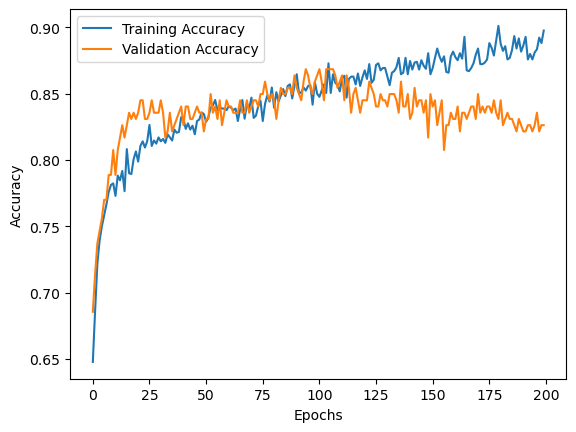

In [14]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

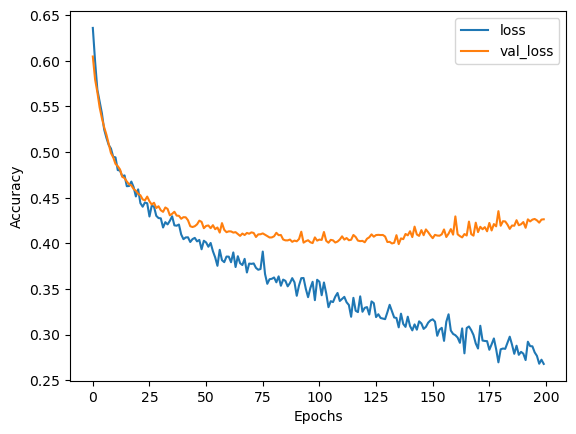

In [15]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [16]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

7/7 [==============================] - 1s 26ms/step


In [17]:
Y_test_original = label_encoder.inverse_transform(Y_test_encoded)
Y_pred_original = label_encoder.inverse_transform(y_pred_classes)

In [18]:
from sklearn.metrics import classification_report
report = classification_report(Y_test_original, Y_pred_original)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

    negative       0.84      0.87      0.85       140
    positive       0.73      0.67      0.70        73

    accuracy                           0.80       213
   macro avg       0.78      0.77      0.78       213
weighted avg       0.80      0.80      0.80       213



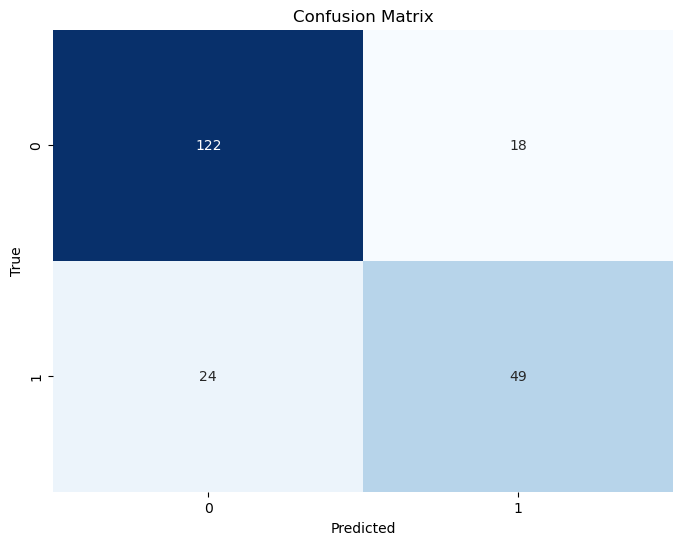

In [19]:
from sklearn.metrics import  confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

confusion = confusion_matrix(Y_test_original, Y_pred_original)

plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

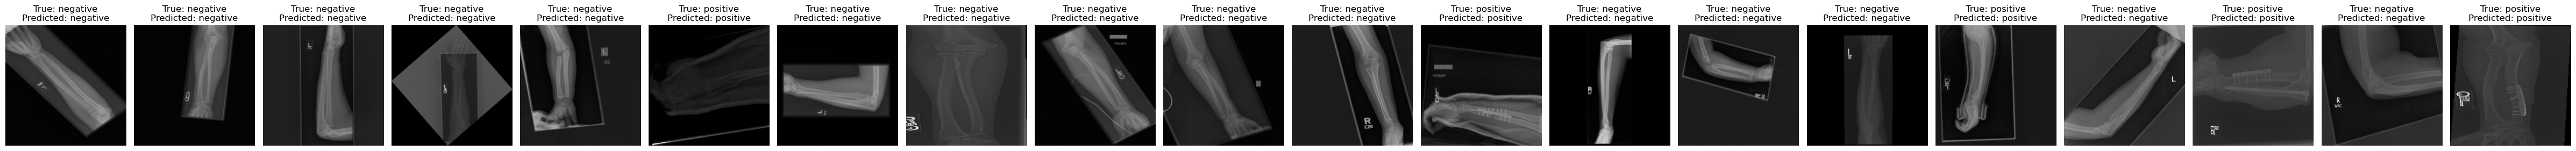

In [23]:
num_images_to_display = 20  
plt.figure(figsize=(48, 8))
for i in range(num_images_to_display):
    plt.subplot(1, num_images_to_display, i + 1)
    plt.imshow(X_test[i])
    plt.title(f'True: {Y_test_original[i]}\nPredicted: {Y_pred_original[i]}')
    plt.axis('off')
plt.tight_layout()
plt.show()

In [24]:
model_filename = "ForearmMobileNet.h5"
model.save(model_filename)

print(f"Model saved as {model_filename}")

Model saved as ForearmMobileNet.h5


In [25]:
import matplotlib.pyplot as plt
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image
import numpy as np
import cv2
import tensorflow as tf
def compute_gradcam(model, img_array, layer_name):
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(layer_name).output, model.output])

    with tf.GradientTape() as tape:
        conv_output, predictions = grad_model(img_array)
        class_idx = np.argmax(predictions[0])
        loss = predictions[:, class_idx]

    output = conv_output[0]
    grads = tape.gradient(loss, conv_output)[0]

    guided_grads = tf.cast(output > 0, 'float32') * tf.cast(grads > 0, 'float32') * grads

    weights = tf.reduce_mean(guided_grads, axis=(0, 1))
    cam = tf.reduce_sum(tf.multiply(weights, output), axis=-1)
    
    cam = cv2.resize(cam.numpy(), (img_array.shape[1], img_array.shape[2]))
    cam = np.maximum(cam, 0)
    cam = (cam - cam.min()) / (cam.max() - cam.min()) 

    return cam 

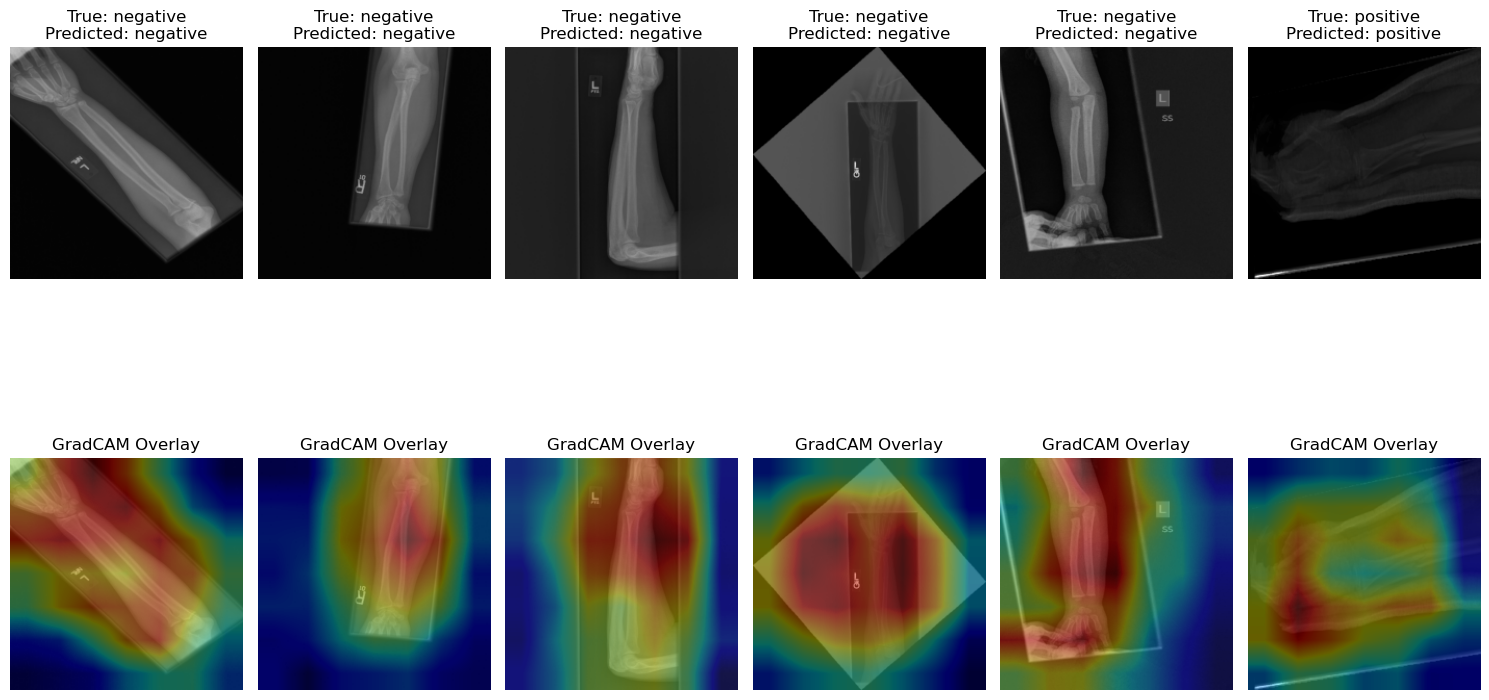

In [26]:
layer_name = 'Conv_1'
num_images_to_display = 6  

plt.figure(figsize=(15, 10))
for i in range(num_images_to_display):
    img = X_test[i]

    img = (img * 255).astype(np.uint8)

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  

    img_array = preprocess_input(np.expand_dims(img, axis=0))  
    cam = compute_gradcam(model, img_array, layer_name)

    cam = (cam - cam.min()) / (cam.max() - cam.min())

    plt.subplot(2, num_images_to_display, i + 1)
    plt.imshow(img, cmap='viridis')  
    plt.title(f'True: {Y_test_original[i]}\nPredicted: {Y_pred_original[i]}')
    plt.axis('off')

    plt.subplot(2, num_images_to_display, i + num_images_to_display + 1)
    plt.imshow(img, cmap='viridis')  
    plt.imshow(cam, cmap='jet', alpha=0.4)
    plt.title('GradCAM Overlay')
    plt.axis('off')

plt.tight_layout()
plt.show()